<a href="https://colab.research.google.com/github/stwind/gan-experiments/blob/master/notebooks/wgan_gp_toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import math

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from fastprogress.fastprogress import progress_bar
from sklearn.datasets import make_swiss_roll
from matplotlib.gridspec import GridSpec

sns.set('notebook', 'whitegrid', rc={
    'font.family': ['DejaVu Sans'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 6),
    'grid.linewidth': 1,
    'grid.alpha': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 13,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 14,
})
plt.style.use("dark_background")

print("versions:")
print("numpy: {}".format(np.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(mpl.__version__))
print("pytorch: {}".format(torch.__version__))
for i in range(torch.cuda.device_count()):
    print("cuda device #{}: {}".format(i, torch.cuda.get_device_name(i)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("current device type: {}".format(device.type))

versions:
numpy: 1.19.4
seaborn: 0.11.0
matplotlib: 3.2.2
pytorch: 1.7.0+cu101
cuda device #0: Tesla T4
current device type: cuda


## Datasets

In [ ]:
def make_radial_points(n=8, radius=2):
    points = np.zeros((n, 2), dtype=np.float32)
    for i in range(n):
        a = 2 * np.pi / n * i
        points[i,:] = math.cos(a) * radius, math.sin(a) * radius
    return points

def make_grid_points(h, w):
    n = h * w
    points = np.zeros((n, 2), dtype=np.float32)
    i = 0
    for r in range(-(h//2),h//2+1):
        for c in range(-(w//2),w//2+1):
            points[i,:] = r, c
            i += 1
    return points

class GaussianMixture(Dataset):
    def __init__(self, centers, size=64, std=0.02):
        points = []
        for _ in range(size):
            point = np.random.randn(2).astype(np.float32) * std
            i = np.random.choice(len(centers));
            points.append(point + centers[i])
        points = np.array(points)
        points /= points.std()
        self.data = points
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
class SwissRoll(Dataset):
    def __init__(self, size=100, noise=0.05):
        self.data = make_swiss_roll(size, noise=noise)[0][:, [0,2]].astype(np.float32)
        self.data /= self.data.std()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

## Models

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.zeros_(m.bias)

class Generator(nn.Module):
    def __init__(self, nz, nc, ngf=512):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(nz, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, nc),
        )

    def forward(self, noise):
        return self.main(noise)

class Discriminator(nn.Module):

    def __init__(self, nc, ndf=512):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(nc, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, 1),
        )

    def forward(self, inputs):
        return self.main(inputs)

In [ ]:
class WGANTrainer(object):
    def __init__(self, dataloader, netD, netG, nz, device=device,
                 epoch_start=0, epoch_end=1000, n_critics=5, gp_lambda=1,
                 lr_d=1e-4, betas_d=(0.5, 0.9), 
                 lr_g=1e-4, betas_g=(0.5, 0.9)):
        self.dataloader = dataloader
        self.netG = netG
        self.netD = netD
        self.device = device
        self.nz = nz
        self.epoch_start = epoch_start
        self.epoch_end = epoch_end
        self.n_critics = 5
        self.gp_lambda = 1
        self.optimizerD = torch.optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.9))
        self.optimizerG = torch.optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.9))
        
        self.G_losses = []
        self.D_losses = []
        self.grad_penalties = []
        self.wd_losses = []
        self.crit_reals = []
        self.crit_fakes = []
        self.disc_maps = []
        
        rang = torch.linspace(-3, 3, 100)
        self.grid = torch.dstack(torch.meshgrid(rang, rang)).to(device)
        
    def compute_gradient_penalty(self, data_real, data_fake):
        alpha = torch.rand(batch_size, 1, device=self.device).expand(data_real.size())
        interpolates = (alpha * data_real + (1 - alpha) * data_fake)
        outputs = self.netD(interpolates)

        gradients = torch.autograd.grad(outputs=outputs, inputs=interpolates,
                                        grad_outputs=torch.ones_like(outputs, device=self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

        return (gradients.norm(2, dim=1) - 1.).square().mean()
        
    def train(self):
        for epoch in progress_bar(range(self.epoch_start, self.epoch_end)):
            for i, data in enumerate(self.dataloader):
                self.optimizerD.zero_grad()

                data_real = data.to(device)
                d_real = self.netD(data_real).mean()

                z = torch.randn(data_real.size(0), self.nz, device=self.device)
                data_fake = self.netG(z)
                d_fake = self.netD(data_fake).mean()

                gradient_penalty = self.compute_gradient_penalty(data_real, data_fake) * self.gp_lambda

                d_loss = d_fake - d_real + gradient_penalty
                d_loss.backward()

                self.optimizerD.step()

                if i % self.n_critics == 0:
                    self.wd_losses.append(d_real - d_fake)

                    self.optimizerG.zero_grad()

                    data_fake = self.netG(z)
                    d_fake = self.netD(data_fake).mean()
                    g_loss = -d_fake
                    g_loss.backward()

                    self.optimizerG.step()

                    self.G_losses.append(g_loss.item())
                    self.D_losses.append(d_loss.item())
                    self.grad_penalties.append(gradient_penalty.item())
                    self.crit_reals.append(d_real.item())
                    self.crit_fakes.append(d_fake.item())

            if epoch % 100 == 0:
                print("[{:>3}/{:>4}][{:>2}/{:>2}] D_Loss: {:.4f} G_Loss: {:.4f} CR: {:.4f} CF: {:.4f} GP: {:.4f}".format(
                    epoch, self.epoch_end, i, len(self.dataloader),
                    self.D_losses[-1], self.G_losses[-1], 
                    self.crit_reals[-1], self.crit_fakes[-1],
                    self.grad_penalties[-1]
                ))
                with torch.no_grad():
                    size = len(self.grid)
                    disc_map = netD(self.grid.view(-1,2)).cpu().view(size,size).numpy()
                self.disc_maps.append(disc_map)
    
    def plot_result(self):
        fig = plt.figure(figsize=(14, 10))

        gs = GridSpec(3, 5, height_ratios=[1.8,1,1])

        ax = plt.subplot(gs[0, :2])
        for p in self.dataloader:
            ax.scatter(p[:,0],p[:,1],alpha=0.7,edgecolor='k')
        ax.set_aspect('equal', 'box')
        sns.despine()

        ax = plt.subplot(gs[0, 2:])
        ax.plot(self.G_losses, label="G Loss", alpha=0.8)
        ax.plot(self.D_losses, label="D Loss", alpha=0.8)
        ax.plot(self.grad_penalties, label="Grad Penalty", alpha=0.8)
        ax.plot(self.crit_reals, label="Crit Real", alpha=0.8)
        ax.plot(self.crit_fakes, label="Crit Fake", alpha=0.8)
        ax.plot(self.wd_losses, label="Wasserstein Dist", alpha=0.8)
        ax.set(xlabel="Time", ylabel="Score", title="Training Process")
        ax.legend()

        data_real = next(iter(self.dataloader))
        with torch.no_grad():
            z = torch.randn(data_real.size(0), nz, device=device)
            data_fake = self.netG(z).cpu()

        grid = self.grid.cpu()
        for i, dm in enumerate(self.disc_maps):
            r, c = divmod(i, 5)
            ax = plt.subplot(gs[1+r, c])
            cf = ax.contourf(grid[:,:,0], grid[:,:,1], dm, 10, alpha=0.9, cmap='viridis')
            ax.scatter(data_real[:, 0], data_real[:, 1], c='tab:blue', marker='.', alpha=0.8)
            ax.scatter(data_fake[:, 0], data_fake[:, 1], c='tab:red', marker='x', alpha=0.5)
            ax.set_aspect('equal', 'box')
            ax.set_title("epoch: {}".format(i * 100), fontdict={'fontsize': 11})

        plt.tight_layout()
        plt.show()

## Gaussian 8

In [ ]:
batch_size = 64
nz = 100
nc = 2
ngf = 512
ndf = 512

dataloader = DataLoader(GaussianMixture(make_radial_points(), batch_size * 10), batch_size=batch_size, shuffle=True)

print("Generator")
netG = Generator(nz, nc, ngf).to(device)
netG.apply(weights_init)
summary(netG, (nz,))

print("Discriminator")
netD = Discriminator(nc, ndf).to(device)
netD.apply(weights_init)
summary(netD, (nc,))

Generator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          51,712
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
              ReLU-6                  [-1, 512]               0
            Linear-7                    [-1, 2]           1,026
Total params: 578,050
Trainable params: 578,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.21
Estimated Total Size (MB): 2.23
----------------------------------------------------------------
Discriminator
----------------------------------------------------------------
        Layer (ty

In [ ]:
trainer = WGANTrainer(dataloader, netD, netG, nz)
trainer.train()

[  0/1000][ 9/10] D_Loss: 0.9942 G_Loss: 0.0012 CR: -0.0014 CF: -0.0012 GP: 0.9938
[100/1000][ 9/10] D_Loss: -0.7142 G_Loss: 0.7608 CR: 0.2338 CF: -0.7608 GP: 0.2172
[200/1000][ 9/10] D_Loss: -0.8729 G_Loss: 1.5210 CR: -0.3181 CF: -1.5210 GP: 0.3074
[300/1000][ 9/10] D_Loss: -0.5029 G_Loss: 7.7599 CR: -7.0993 CF: -7.7599 GP: 0.0913
[400/1000][ 9/10] D_Loss: -0.5010 G_Loss: 7.1812 CR: -6.6244 CF: -7.1812 GP: 0.0710
[500/1000][ 9/10] D_Loss: -0.4191 G_Loss: 6.2868 CR: -5.8275 CF: -6.2868 GP: 0.0434
[600/1000][ 9/10] D_Loss: -0.3513 G_Loss: 5.1272 CR: -4.7286 CF: -5.1272 GP: 0.0334
[700/1000][ 9/10] D_Loss: -0.3391 G_Loss: 3.8973 CR: -3.5174 CF: -3.8973 GP: 0.0233
[800/1000][ 9/10] D_Loss: -0.2793 G_Loss: 3.2194 CR: -2.9182 CF: -3.2194 GP: 0.0242
[900/1000][ 9/10] D_Loss: -0.2589 G_Loss: 2.9182 CR: -2.6485 CF: -2.9182 GP: 0.0227


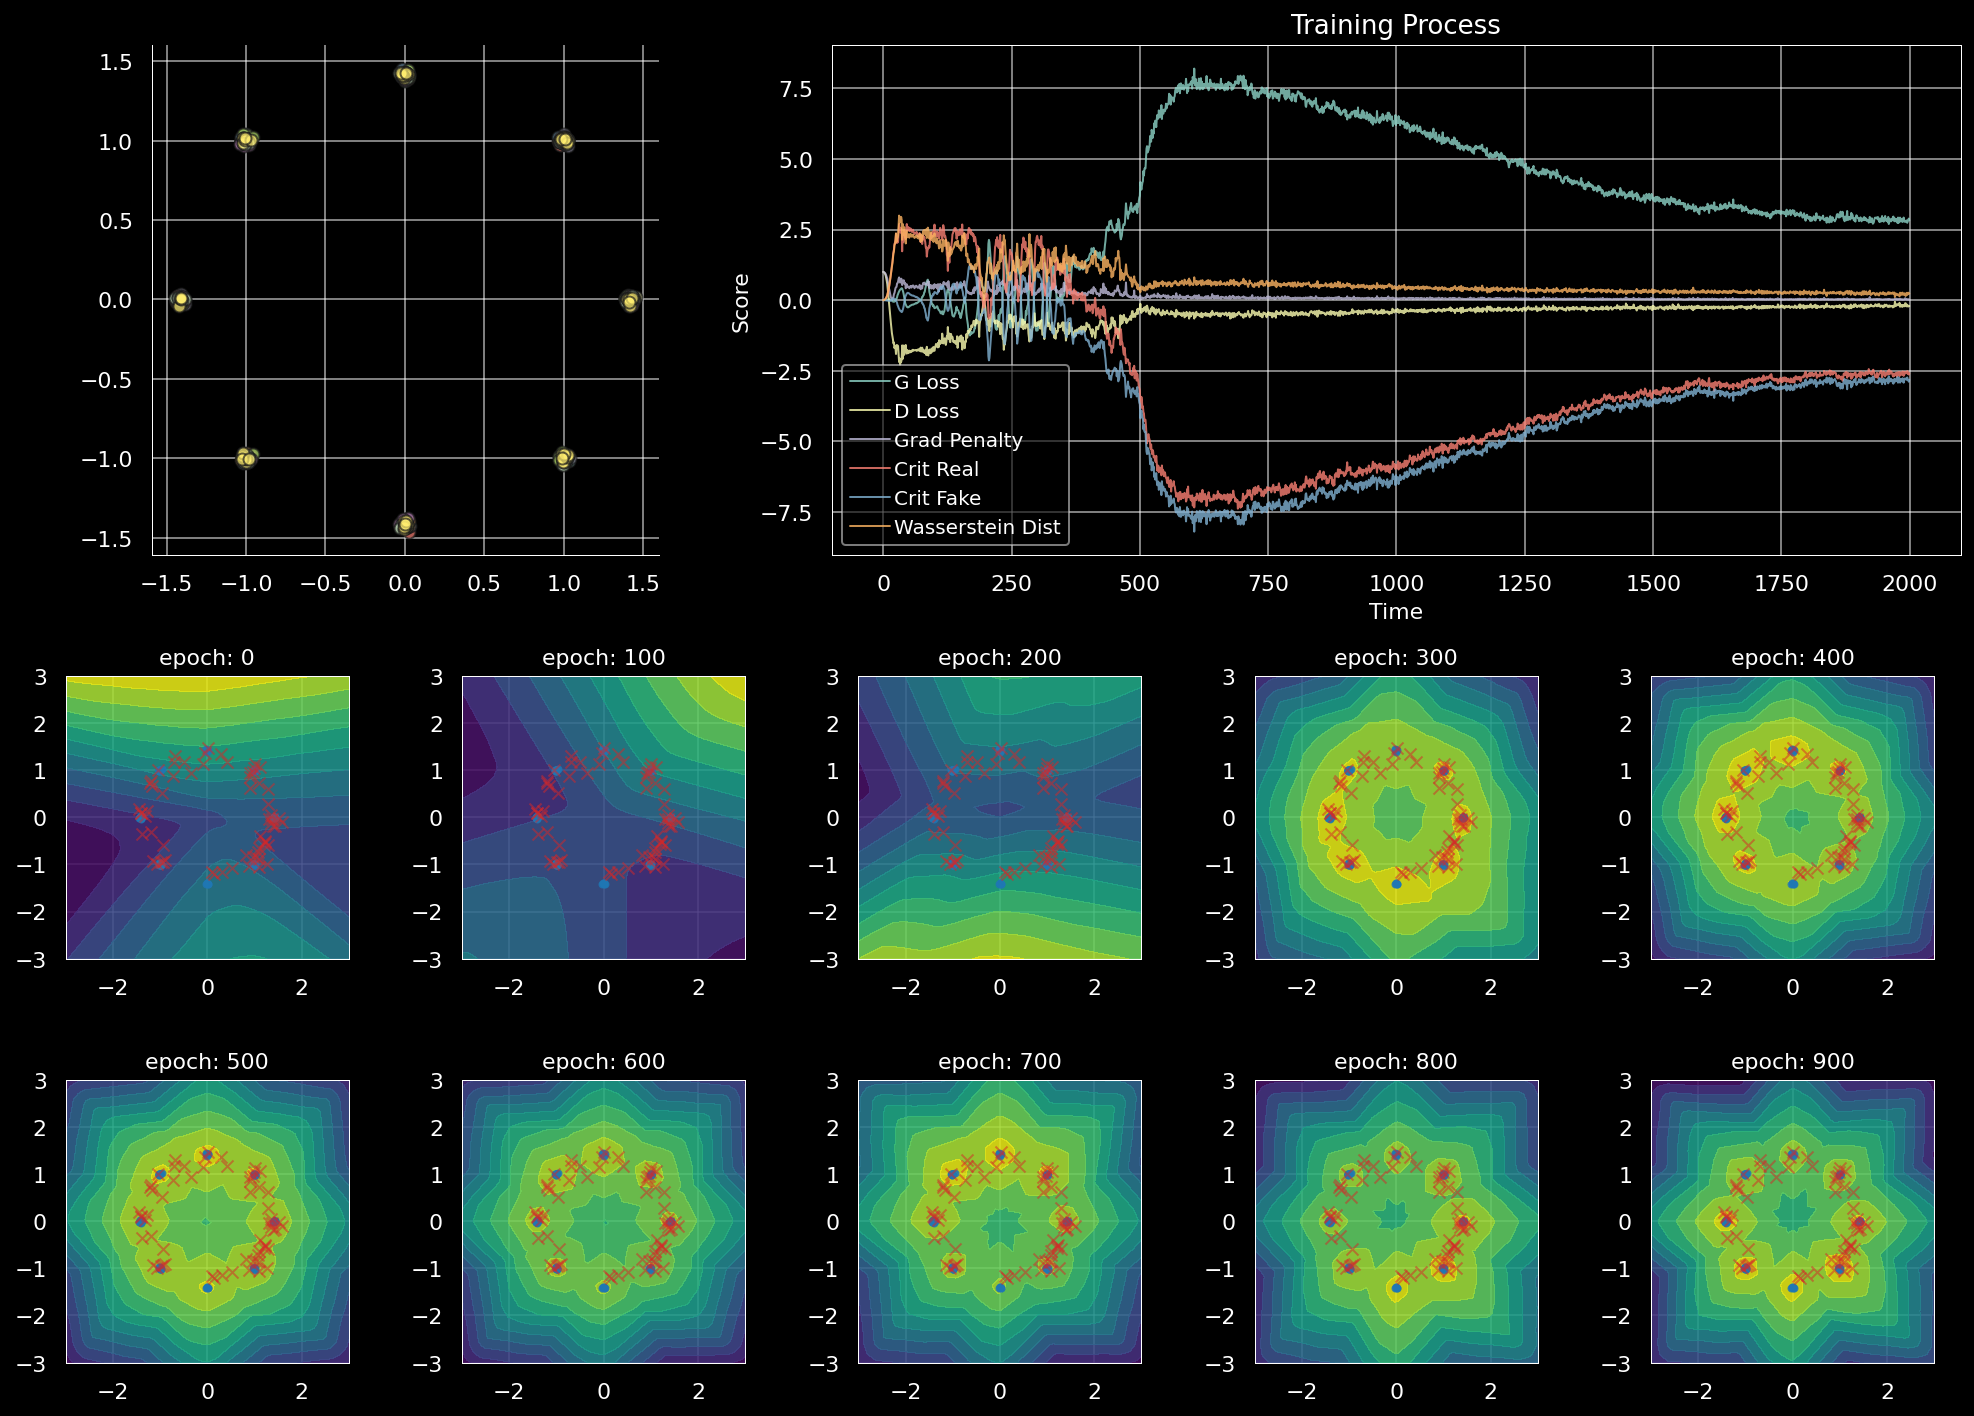

In [ ]:
trainer.plot_result()

## Gaussian 25

In [55]:
batch_size = 64
nz = 100
nc = 2
ngf = 512
ndf = 512

dataloader = DataLoader(GaussianMixture(make_grid_points(5, 5), batch_size * 10), batch_size=batch_size, shuffle=True)

print("Generator")
netG = Generator(nz, nc, ngf).to(device)
netG.apply(weights_init)
summary(netG, (nz,))

print("Discriminator")
netD = Discriminator(nc, ndf).to(device)
netD.apply(weights_init)
summary(netD, (nc,))

Generator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          51,712
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
              ReLU-6                  [-1, 512]               0
            Linear-7                    [-1, 2]           1,026
Total params: 578,050
Trainable params: 578,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.21
Estimated Total Size (MB): 2.23
----------------------------------------------------------------
Discriminator
----------------------------------------------------------------
        Layer (ty

In [56]:
trainer = WGANTrainer(dataloader, netD, netG, nz)
trainer.train()

[  0/1000][ 9/10] D_Loss: 0.9795 G_Loss: 0.0011 CR: 0.0071 CF: -0.0011 GP: 0.9874
[100/1000][ 9/10] D_Loss: -0.6676 G_Loss: -0.3921 CR: 1.3889 CF: 0.3921 GP: 0.3354
[200/1000][ 9/10] D_Loss: 0.2792 G_Loss: 1.6363 CR: -1.8186 CF: -1.6363 GP: 0.0977
[300/1000][ 9/10] D_Loss: -0.1981 G_Loss: 4.5353 CR: -4.1195 CF: -4.5353 GP: 0.0983
[400/1000][ 9/10] D_Loss: -0.0441 G_Loss: 6.5459 CR: -6.3519 CF: -6.5459 GP: 0.0357
[500/1000][ 9/10] D_Loss: -0.1029 G_Loss: 5.9987 CR: -5.8131 CF: -5.9987 GP: 0.0571
[600/1000][ 9/10] D_Loss: 0.0083 G_Loss: 5.5707 CR: -5.5268 CF: -5.5707 GP: 0.0719
[700/1000][ 9/10] D_Loss: -0.1853 G_Loss: 4.0633 CR: -3.8045 CF: -4.0633 GP: 0.0579
[800/1000][ 9/10] D_Loss: -0.1938 G_Loss: 3.6478 CR: -3.4674 CF: -3.6478 GP: 0.0470
[900/1000][ 9/10] D_Loss: -0.2213 G_Loss: 2.5646 CR: -2.3487 CF: -2.5646 GP: 0.0379


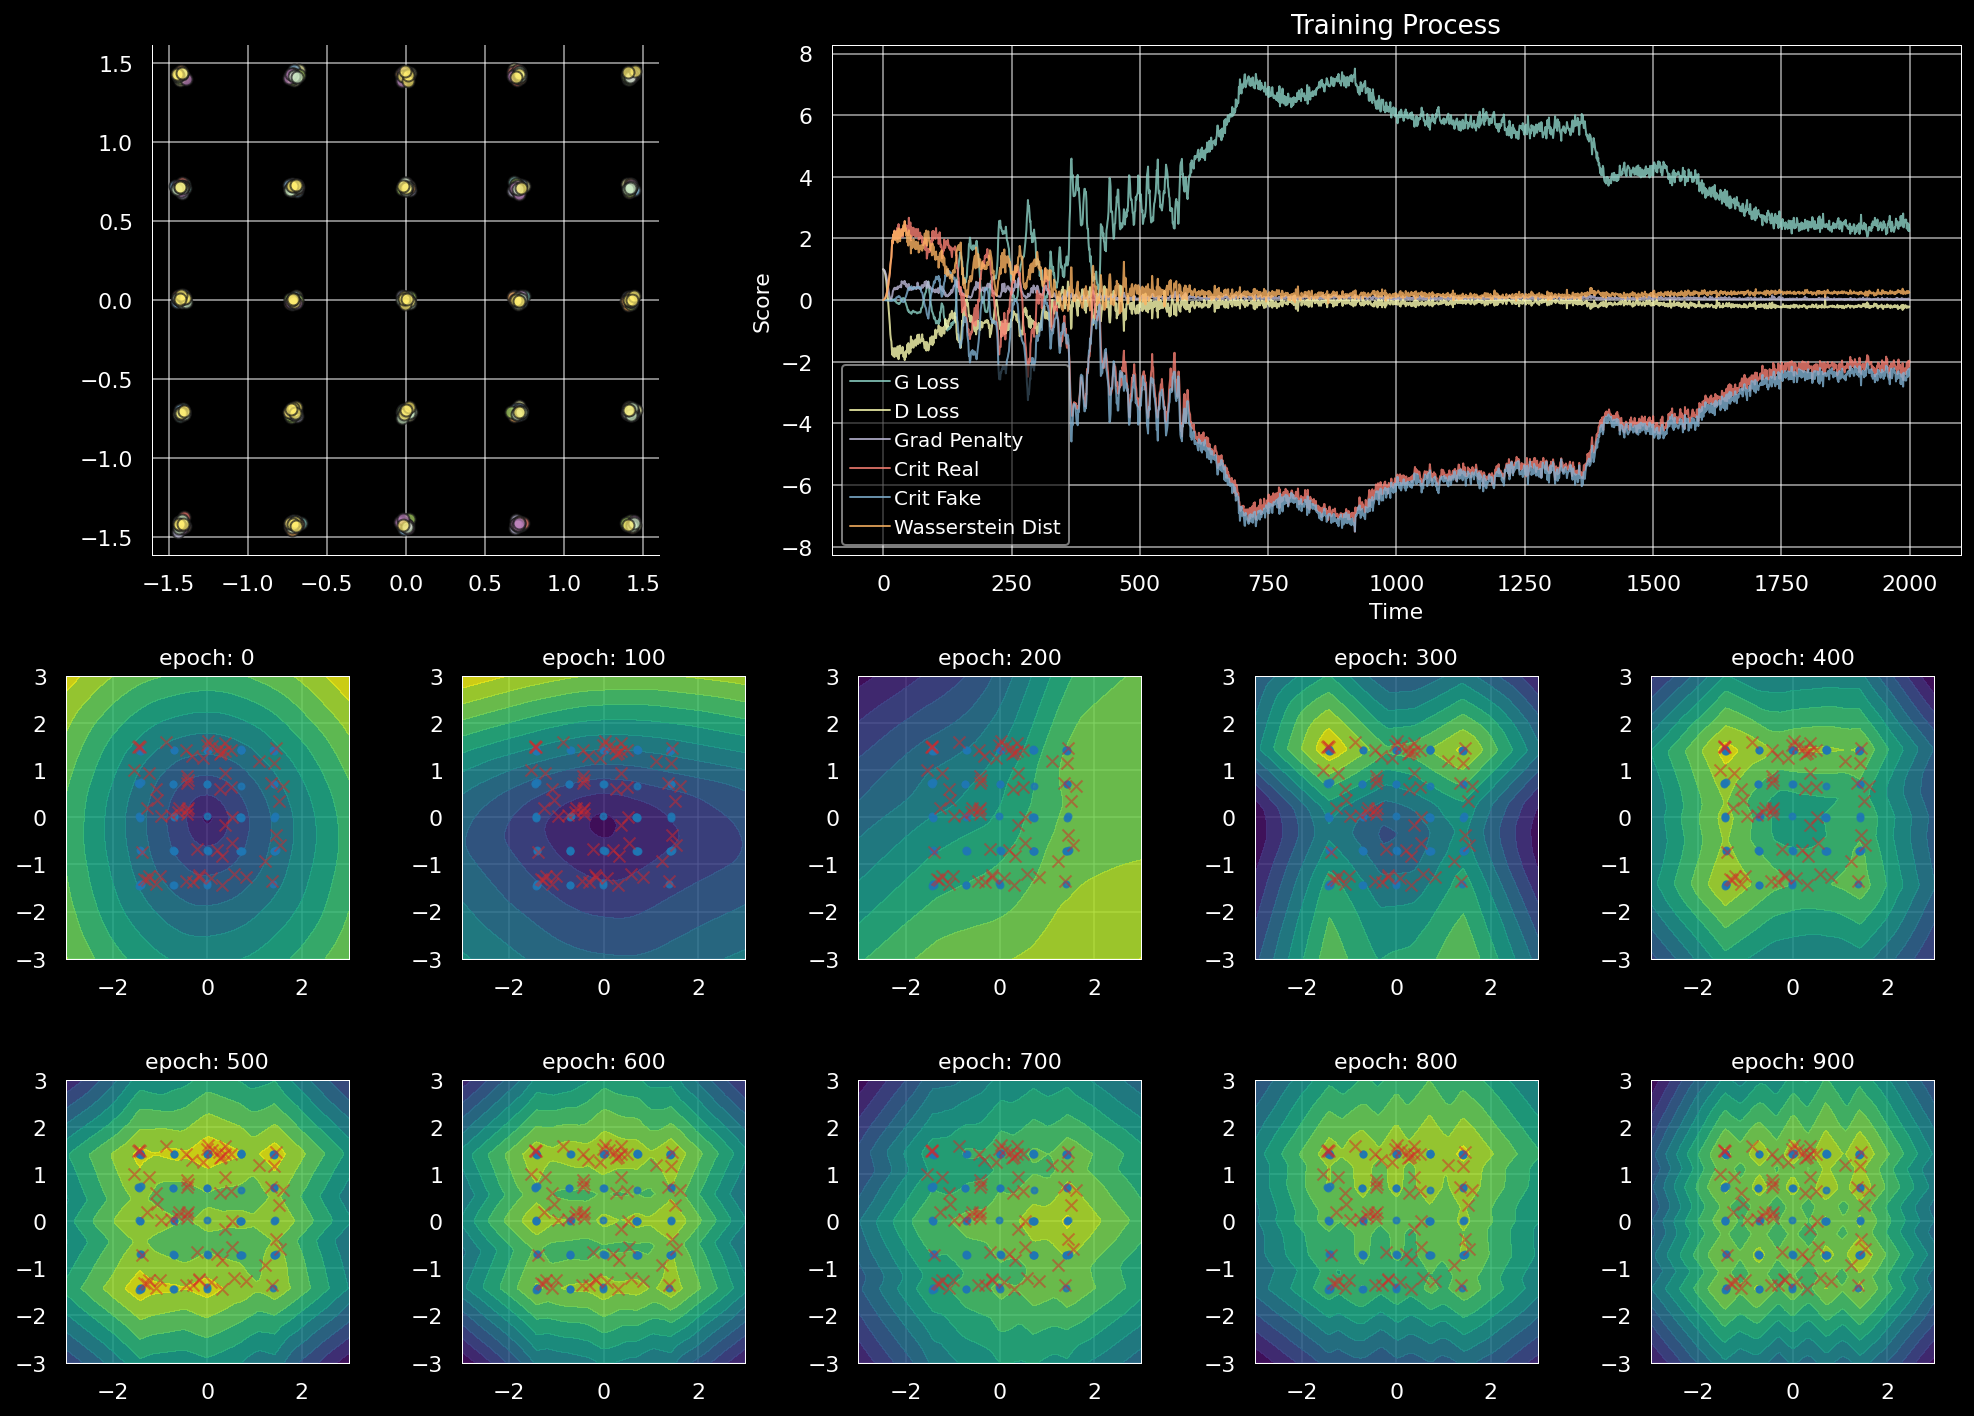

In [57]:
trainer.plot_result()

## Swiss Roll

In [52]:
batch_size = 64
nz = 100
nc = 2
ngf = 512
ndf = 512

dataloader = DataLoader(SwissRoll(batch_size * 10), batch_size=batch_size, shuffle=True)

print("Generator")
netG = Generator(nz, nc, ngf).to(device)
netG.apply(weights_init)
summary(netG, (nz,))

print("Discriminator")
netD = Discriminator(nc, ndf).to(device)
netD.apply(weights_init)
summary(netD, (nc,))

Generator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          51,712
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
              ReLU-6                  [-1, 512]               0
            Linear-7                    [-1, 2]           1,026
Total params: 578,050
Trainable params: 578,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.21
Estimated Total Size (MB): 2.23
----------------------------------------------------------------
Discriminator
----------------------------------------------------------------
        Layer (ty

In [53]:
trainer = WGANTrainer(dataloader, netD, netG, nz)
trainer.train()

[  0/1000][ 9/10] D_Loss: 0.9881 G_Loss: 0.0011 CR: 0.0027 CF: -0.0011 GP: 0.9917
[100/1000][ 9/10] D_Loss: -1.4330 G_Loss: -0.5996 CR: 2.5208 CF: 0.5996 GP: 0.4869
[200/1000][ 9/10] D_Loss: 0.2513 G_Loss: 0.4120 CR: -0.2776 CF: -0.4120 GP: 0.3774
[300/1000][ 9/10] D_Loss: -0.1679 G_Loss: 4.6957 CR: -4.4212 CF: -4.6957 GP: 0.1172
[400/1000][ 9/10] D_Loss: -0.1889 G_Loss: 5.3717 CR: -5.0773 CF: -5.3717 GP: 0.0984
[500/1000][ 9/10] D_Loss: -0.2119 G_Loss: 4.8470 CR: -4.5762 CF: -4.8470 GP: 0.0643
[600/1000][ 9/10] D_Loss: -0.2510 G_Loss: 4.4139 CR: -4.0584 CF: -4.4139 GP: 0.0765
[700/1000][ 9/10] D_Loss: -0.1088 G_Loss: 4.0903 CR: -3.8609 CF: -4.0903 GP: 0.0857
[800/1000][ 9/10] D_Loss: -0.1048 G_Loss: 4.3651 CR: -4.2217 CF: -4.3651 GP: 0.0379
[900/1000][ 9/10] D_Loss: -0.1666 G_Loss: 4.2826 CR: -4.0214 CF: -4.2826 GP: 0.0712


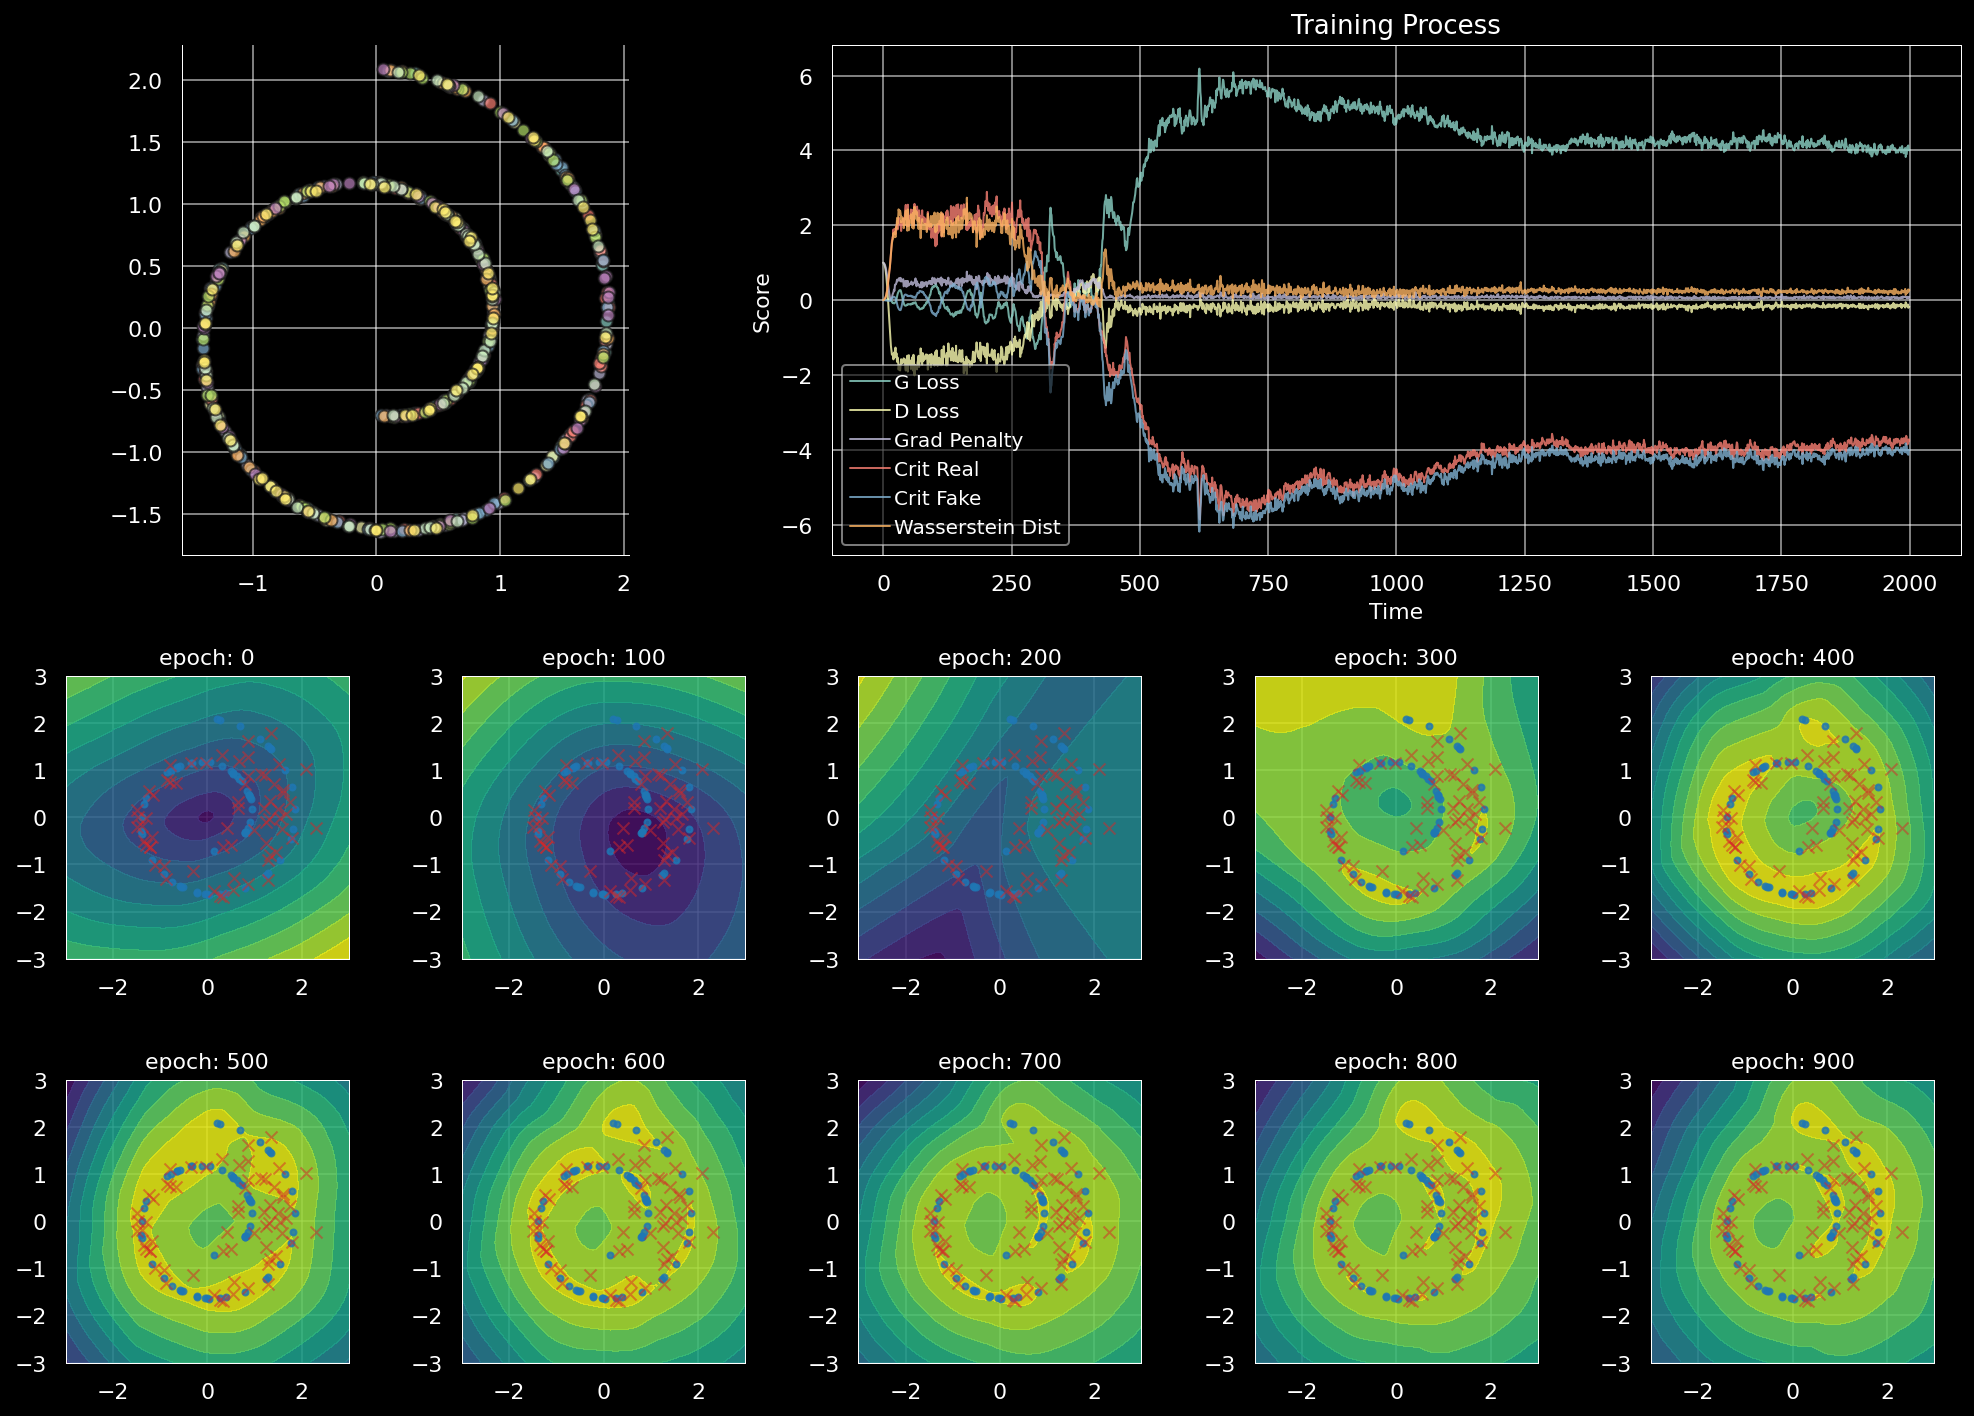

In [54]:
trainer.plot_result()